# Setup: Importing Libraries
In this cell, we import the necessary libraries for model training and tokenization. 
We use `torch` for handling the neural network and `sklearn` for splitting the dataset.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NillionNetwork/aivm/blob/main/examples/2b-fine-tuning-lenet5.ipynb)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset


if torch.backends.mps.is_available():
    print(f"GPU is available.")
else:
    print("No GPU available. Training will run on CPU.")

/Users/pedrolourenco/Documents/Web3/Nillion-Med-Translator/nillion-med-translator/model/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available.


In [2]:
# load dataset
labels = [
    "Mild demented", 
    "Moderate demented", 
    "Non demented", 
    "Very mild demented"
]

ds = load_dataset("Falah/Alzheimer_MRI")

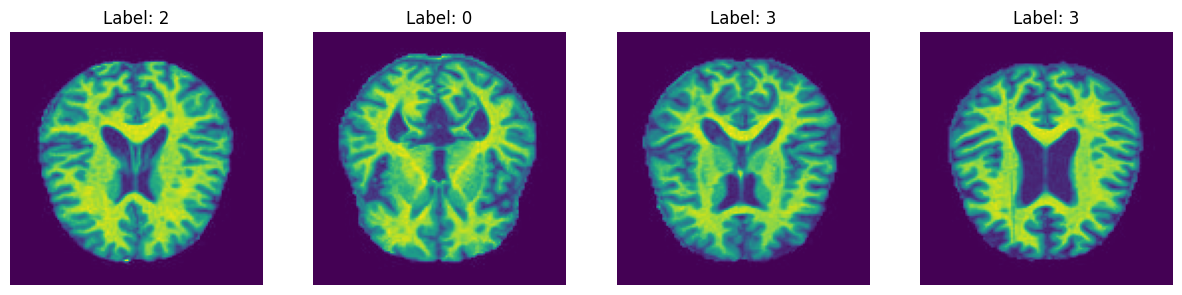

In [3]:
# Plot images from the dataset
import matplotlib.pyplot as plt
import numpy as np

def plot_images(dataset, num_images=4):
  """Plots a specified number of images from the dataset."""
  fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(num_images):
    image = dataset['train'][i]['image']
    image = np.array(image)
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f"Label: {dataset['train'][i]['label']}")
  plt.show()


plot_images(ds)


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Define transformation: Resize to 28x28 and convert to grayscale
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5,), (1.0,))
])

# Apply transformation to the dataset
def transform_dataset(example):
    # Apply the transform on the 'image' field
    image = example['image']
    image = transform(image)
    example['image'] = image
    return example

# Apply transform to the dataset
ds = ds.with_format("torch")
ds = ds.map(transform_dataset)

ds['train'] = ds['train'].shuffle(seed=42)
ds = ds['train'].train_test_split(test_size=0.1)

# get data loaders
train_loader = torch.utils.data.DataLoader([(x, y) for x,y in zip(ds['train']['image'], ds['train']['label'])], batch_size=32)
test_loader = torch.utils.data.DataLoader([(x, y) for x,y in zip(ds['test']['image'], ds['test']['label'])], batch_size=32)

Map: 100%|██████████| 512/512 [00:00<00:00, 2936.26 examples/s]


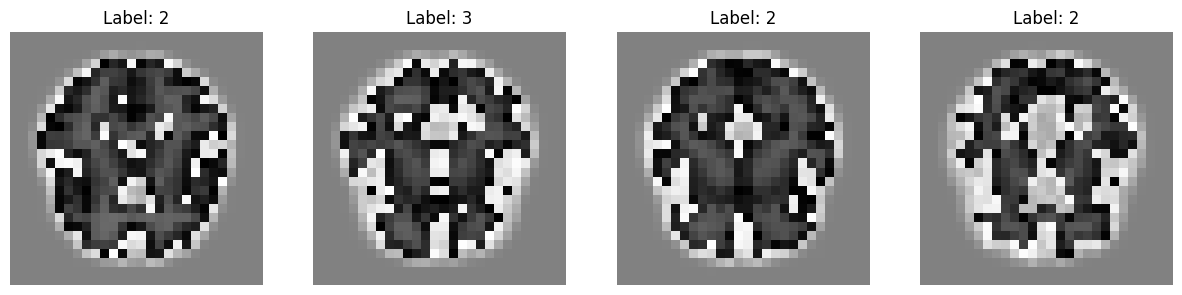

In [6]:
# plot the images after preprocessing

import matplotlib.pyplot as plt

def plot_transformed_images(dataset, num_images=4):
  """Plots a specified number of images from the transformed dataset."""
  fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(num_images):
    image = dataset['train'][i]['image'].permute(1, 2, 0).numpy()  # Move channel dimension to the end
    axs[i].imshow(image, cmap='gray')  # Display grayscale image
    axs[i].axis('off')
    axs[i].set_title(f"Label: {dataset['train'][i]['label']}")
  plt.show()


plot_transformed_images(ds)


In [18]:
#define the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [36]:
#Define LeNet5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.flattener = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


network = LeNet5()
network.to(device)

# Instantiate a torch loss function
loss_fn = nn.CrossEntropyLoss()


In [44]:

optimizer = optim.Adam(network.parameters(), lr=5e-4)

def train(epoch):
    network.train() #put model in training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        #perform forward pass + back propagation
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = network(data)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    
    #put model in evaluation mode
    network.eval()
    train_loss = 0
    correct = 0
    
    #calculate evaluation metrics (on test dataset)
    with torch.no_grad(): 
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            #print(data.shape)
            logits = network(data)
            train_loss += loss_fn(logits, target).item()
            pred = logits.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    train_loss /= len(train_loader.dataset)
    print('\nTraining set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    train_loss, correct, len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))


In [45]:

def test():
  #calculate metrics on evaluation dataset
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
100. * correct / len(test_loader.dataset)))


In [46]:
N_EPOCHS = 50
for epoch in range(1, N_EPOCHS + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/4147 (0%)]	Loss: 0.077899
Train Epoch: 1 [3200/4147 (77%)]	Loss: 0.009096

Training set: Avg. loss: 0.0009, Accuracy: 4107/4147 (99%)


Test set: Avg. loss: -7.2333, Accuracy: 317/461 (69%)

Train Epoch: 2 [0/4147 (0%)]	Loss: 0.031565


/Users/pedrolourenco/Documents/Web3/Nillion-Med-Translator/nillion-med-translator/model/env/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [3200/4147 (77%)]	Loss: 0.004338

Training set: Avg. loss: 0.0008, Accuracy: 4118/4147 (99%)


Test set: Avg. loss: -6.8014, Accuracy: 314/461 (68%)

Train Epoch: 3 [0/4147 (0%)]	Loss: 0.007691
Train Epoch: 3 [3200/4147 (77%)]	Loss: 0.012331

Training set: Avg. loss: 0.0010, Accuracy: 4094/4147 (99%)


Test set: Avg. loss: -6.1431, Accuracy: 312/461 (68%)

Train Epoch: 4 [0/4147 (0%)]	Loss: 0.026684
Train Epoch: 4 [3200/4147 (77%)]	Loss: 0.013675

Training set: Avg. loss: 0.0012, Accuracy: 4085/4147 (99%)


Test set: Avg. loss: -6.4326, Accuracy: 311/461 (67%)

Train Epoch: 5 [0/4147 (0%)]	Loss: 0.005681
Train Epoch: 5 [3200/4147 (77%)]	Loss: 0.003238

Training set: Avg. loss: 0.0013, Accuracy: 4090/4147 (99%)


Test set: Avg. loss: -6.6565, Accuracy: 311/461 (67%)

Train Epoch: 6 [0/4147 (0%)]	Loss: 0.004020
Train Epoch: 6 [3200/4147 (77%)]	Loss: 0.000626

Training set: Avg. loss: 0.0017, Accuracy: 4056/4147 (98%)


Test set: Avg. loss: -6.2914, Accuracy: 312/461 (68%)


In [47]:
torch.save(network.to('cpu').state_dict(), "./saved-models/alzheimer-image-classifier.pth")

In [29]:
#upload model to nillion
import aivm_client as aic

MODEL_NAME = "ALZHEIMER_IMG_CLASSIFIER"
aic.upload_lenet5_model("./saved-models/alzheimer-image-classifier.pth", MODEL_NAME)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INTERNAL
	details = "Error receiving model: Model ALZHEIMER_IMG_CLASSIFIER already exists"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:50050 {grpc_message:"Error receiving model: Model ALZHEIMER_IMG_CLASSIFIER already exists", grpc_status:13, created_time:"2024-10-26T17:12:48.450253+01:00"}"
>

In [30]:
aic.get_supported_models()

['BertTinySMS', 'LeNet5MNIST', 'ALZHEIMER_IMG_CLASSIFIER']

In [31]:
#load demo image from dataset and run secure inference
from datasets import load_dataset
from torchvision import transforms

img_tensor = transform(ds["train"][1]["image"])
encrypted_input = aic.LeNet5Cryptensor(img_tensor.reshape(1, 1, 28, 28))
prediction_cls = torch.argmax(aic.get_prediction(encrypted_input, MODEL_NAME)[0])


In [34]:
labels[prediction_cls]

'Very mild demented'